In [1]:
library(rstan)
library(here)

# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング



In [1]:
# 分析対象のデータを読み込みMCMCする
file_beer_sales_1 <- read.csv(here("./data/2-4-1-beer-sales-1.csv"))
sample_size <- nrow(file_beer_sales_1)
data_list <- list(sales = file_beer_sales_1$sales, N = sample_size)
mcmc_result <- stan(
  file = here("2部", "2-4-1-calc-mean-variance.stan"),
  data = data_list,
  seed = 1,
  chains = 4,
  iter = 2000,
  warmup = 1000,
  thin = 1
)


ERROR: Error in here("./data/2-4-1-beer-sales-1.csv"): 関数 "here" を見つけることができませんでした


In [4]:
# サンプル抽出
mcmc_sample <- rstan::extract(mcmc_result, permuted = FALSE)


In [5]:
class(mcmc_sample)


[1] "array"

In [6]:
dim(mcmc_sample)


[1] 1000    4    3

In [7]:
dimnames(mcmc_sample)


$iterations
NULL

$chains
[1] "chain:1" "chain:2" "chain:3" "chain:4"

$parameters
[1] "mu"    "sigma" "lp__"

In [8]:
mcmc_sample[1, "chain:1", "mu"]


[1] 104.0472

In [9]:
length(mcmc_sample[, "chain:1", "mu"])


[1] 1000

In [10]:
length(mcmc_sample[, , "mu"])


[1] 4000

In [11]:
# ベクトルにする
mu_mcmc_vec <- as.vector(mcmc_sample[, , "mu"])


In [15]:
summary(mu_mcmc_vec)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  96.12  100.89  102.17  102.14  103.39  109.90 

In [17]:
# 95%ベイズ信用区間
quantile(mu_mcmc_vec, probs = c(0.025, 0.975))


2.5%    97.5% 
 98.4835 105.7341

In [19]:
package.install(ggfortify)


ERROR: Error in package.install(ggfortify): 関数 "package.install" を見つけることができませんでした


要求されたパッケージ ggplot2 をロード中です



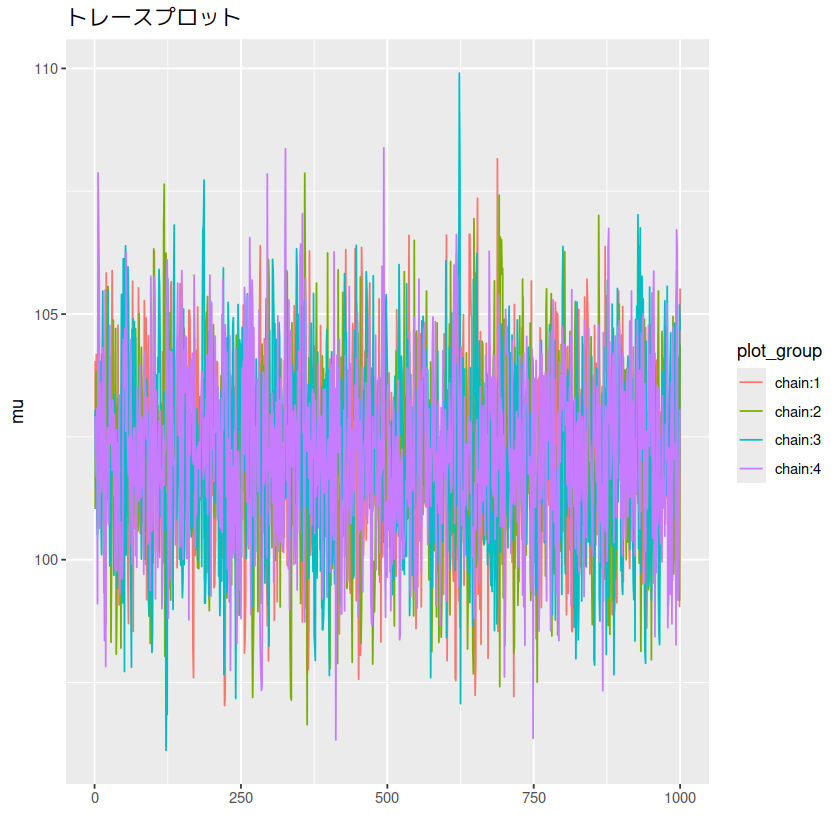

In [20]:
library(ggfortify)
autoplot(ts(mcmc_sample[, , "mu"]),
  facets = F,
  ylab = "mu",
  main = "トレースプロット"
)


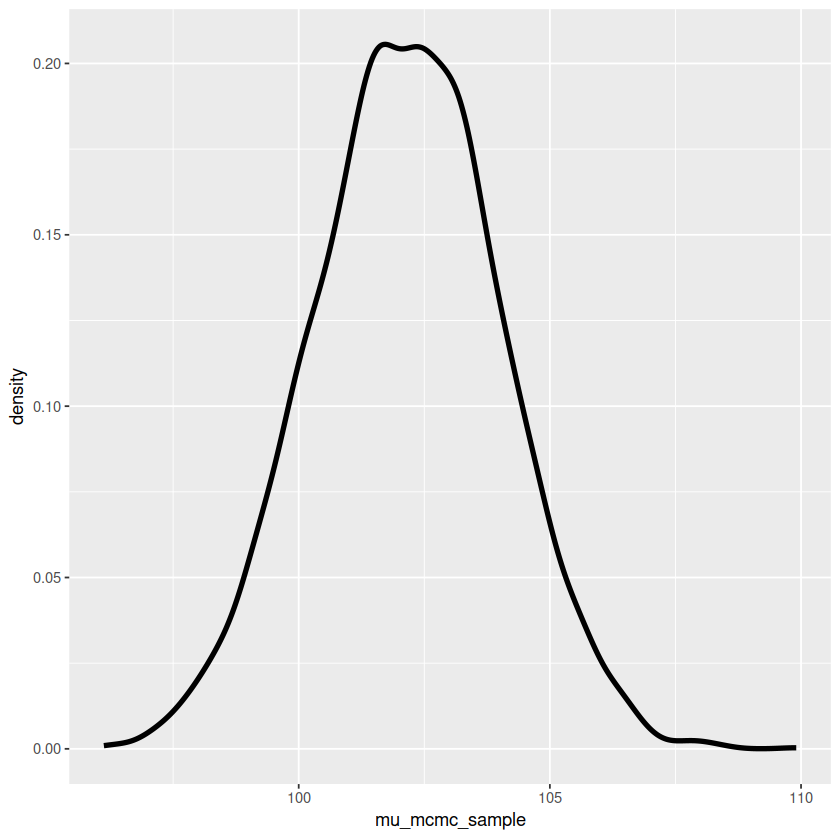

In [23]:
# ggplot2で事後分布の可視化
mu_df <- data.frame(
  mu_mcmc_sample = mu_mcmc_vec
)
ggplot(data = mu_df, mapping = aes(x = mu_mcmc_sample)) +
  geom_density(linewidth = 1.5)


In [27]:
# baseplotで事後分布可視化
library(bayesplot)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


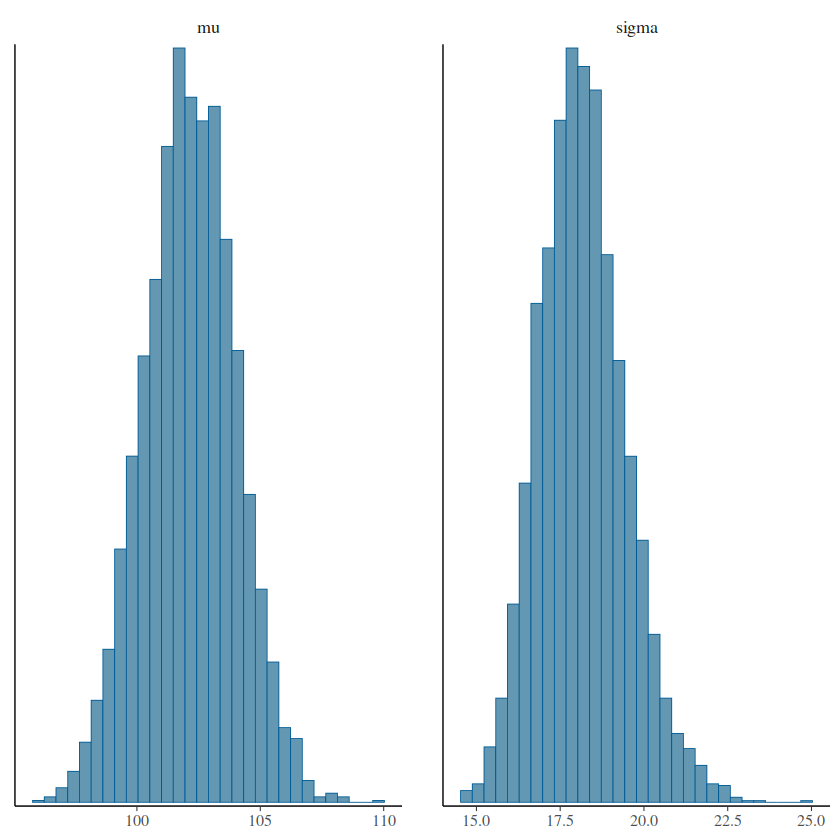

In [29]:
mcmc_hist(mcmc_sample, pars = c("mu", "sigma"))


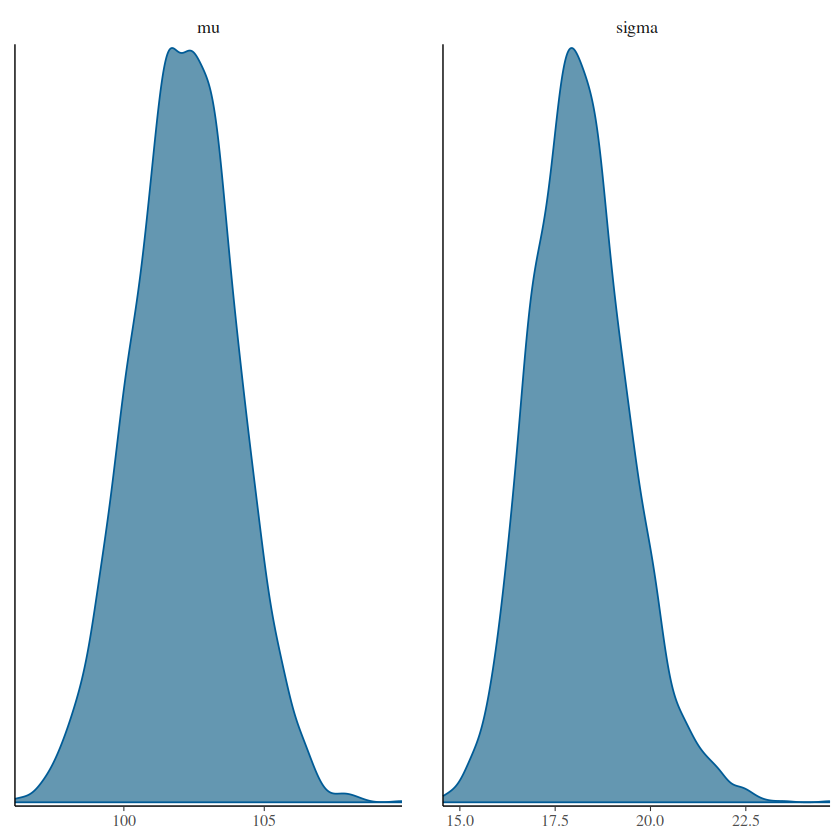

In [30]:
mcmc_dens(mcmc_sample, pars = c("mu", "sigma")) # カーネル密度分布


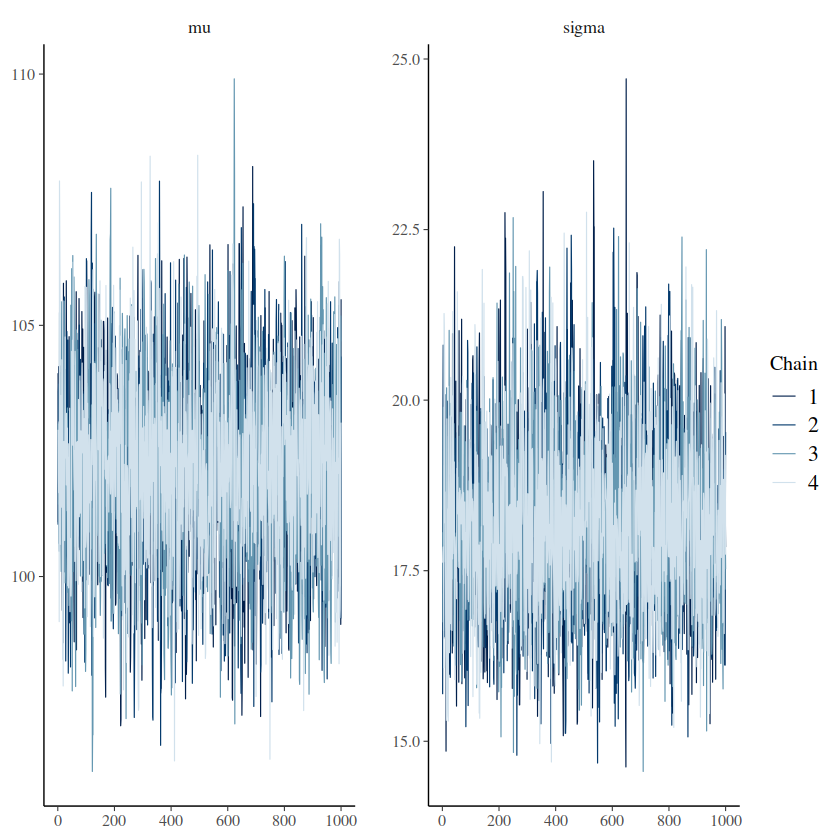

In [31]:
mcmc_trace(mcmc_sample, pars = c("mu", "sigma"))


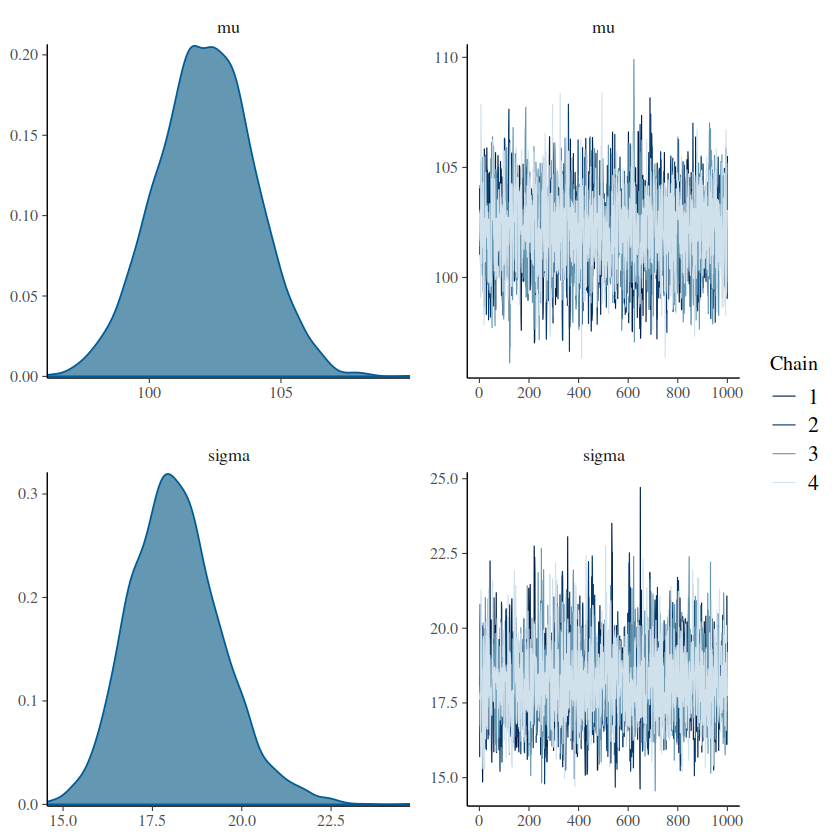

In [32]:
# 事後分布とトレースプロットまとめて表示
mcmc_combo(mcmc_sample, pars = c("mu", "sigma"))


In [3]:
# 事後分布の範囲の比較
mcmc_intervals(
  mcmc_sample,
  pars = c("mu", "sigma"),
  prob = 0.8, # 太い線の範囲
  prob_outer = 0.95 # 細い線の範囲
)


ERROR: Error in mcmc_intervals(mcmc_sample, pars = c("mu", "sigma"), prob = 0.8, : 関数 "mcmc_intervals" を見つけることができませんでした


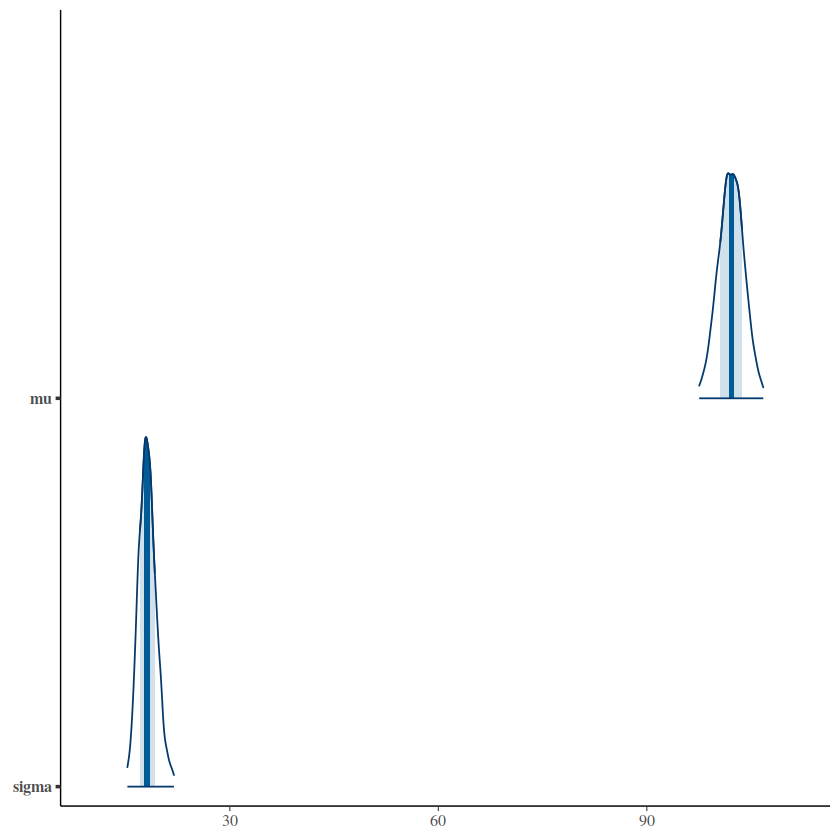

In [37]:
mcmc_areas(
  mcmc_sample,
  pars = c("mu", "sigma"),
  prob = 0.6,
  prob_outer = 0.99
)


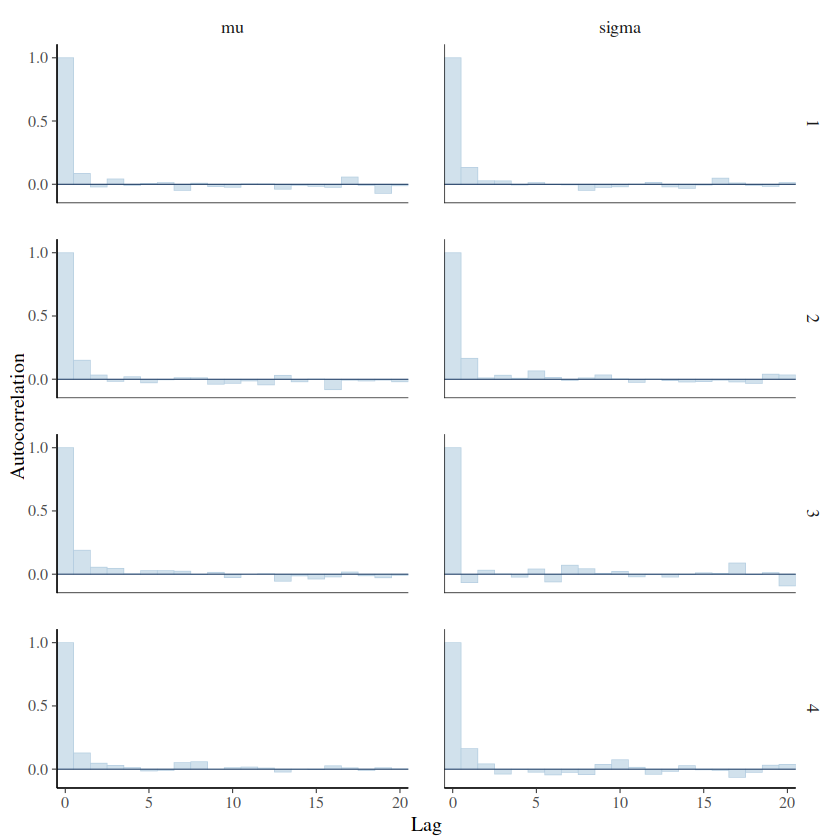

In [38]:
# コレログラム
mcmc_acf_bar(mcmc_sample, pars = c("mu", "sigma"))


In [7]:
# 事後予測チェックの概要
# load data
animal_num <- read.csv(here("data", "2-5-1-animal-num.csv"))
head(animal_num, n = 3)


,animal_num
,<int>
1,0
2,1
3,1


In [13]:
sample_size <- nrow(animal_num)
data_list <- list(animal_num = animal_num$animal_num, N = sample_size)

# 正規分布仮定のモデル
mcmc_normal <- stan(
  file = here("2部", "2-5-1-normal-dist.stan"),
  data = data_list,
  seed = 1
)
# ポアソン分布
mcmc_poisson <- stan(
  file = here("2部", "2-5-1-poisson-dist.stan"),
  data = data_list,
  seed = 1
)


recompiling to avoid crashing R session



In [17]:
y_rep_normal <- rstan::extract(mcmc_normal)$pred
y_rep_poisson <- rstan::extract(mcmc_poisson)$pred


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


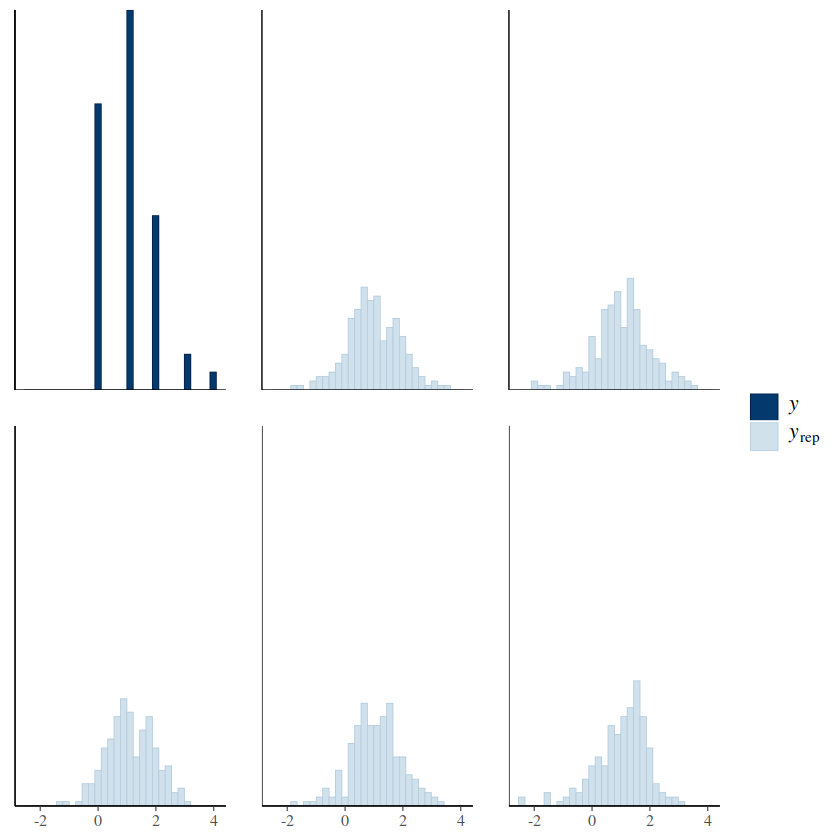

In [18]:
library(bayesplot)
# 観測データと事後予想分布の比較
ppc_hist(
  y = animal_num$animal_num,
  yrep = y_rep_normal[1:5, ]
)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


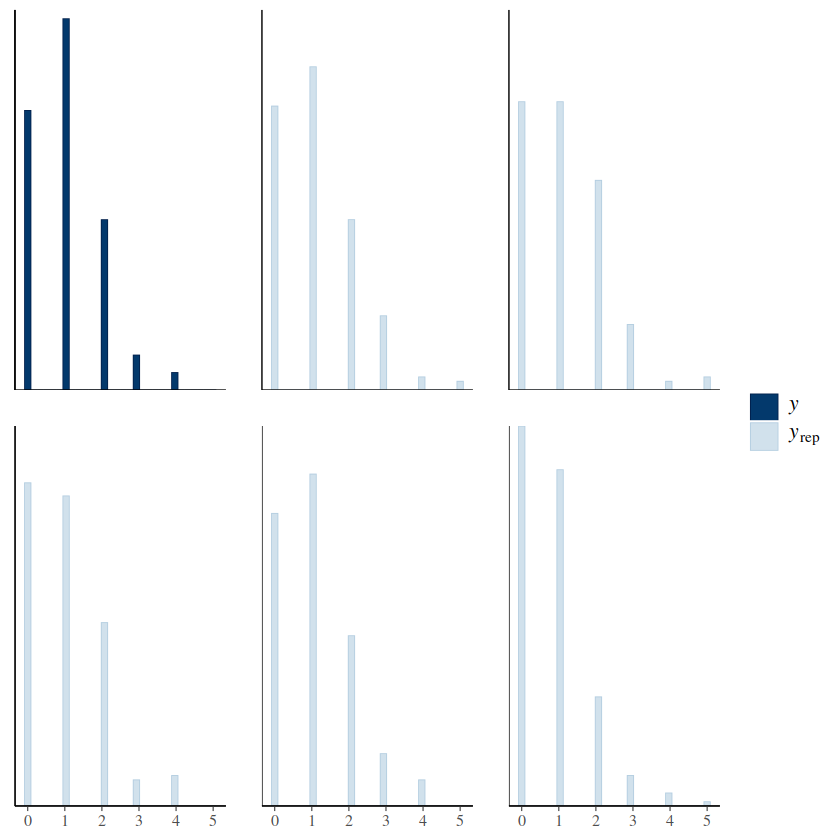

In [19]:
ppc_hist(
  y = animal_num$animal_num,
  yrep = y_rep_poisson[1:5, ]
)
